In [1]:
import pandas as pd
covid19World = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')

In [2]:
covid19SG = covid19World.loc[covid19World['location']=='Singapore']
covid19SG = covid19SG.loc[covid19SG['total_cases']>0]
covid19DailyCase = covid19SG.loc[:,['date','total_cases','new_cases']]
covid19DailyCase = covid19DailyCase.reset_index(drop=True)
covid19DailyCase['new_cases']= covid19DailyCase['new_cases'].astype(int)
covid19DailyCase['total_cases']= covid19DailyCase['total_cases'].astype(int)
covid19DailyCase.describe()

,total_cases,new_cases
count,114.000000,114.000000
mean,4625.359649,235.885965
std,7751.652450,362.545957
min,3.000000,0.000000
25%,85.250000,3.000000
50%,365.000000,15.500000
75%,4894.250000,447.000000
max,26891.000000,1515.000000


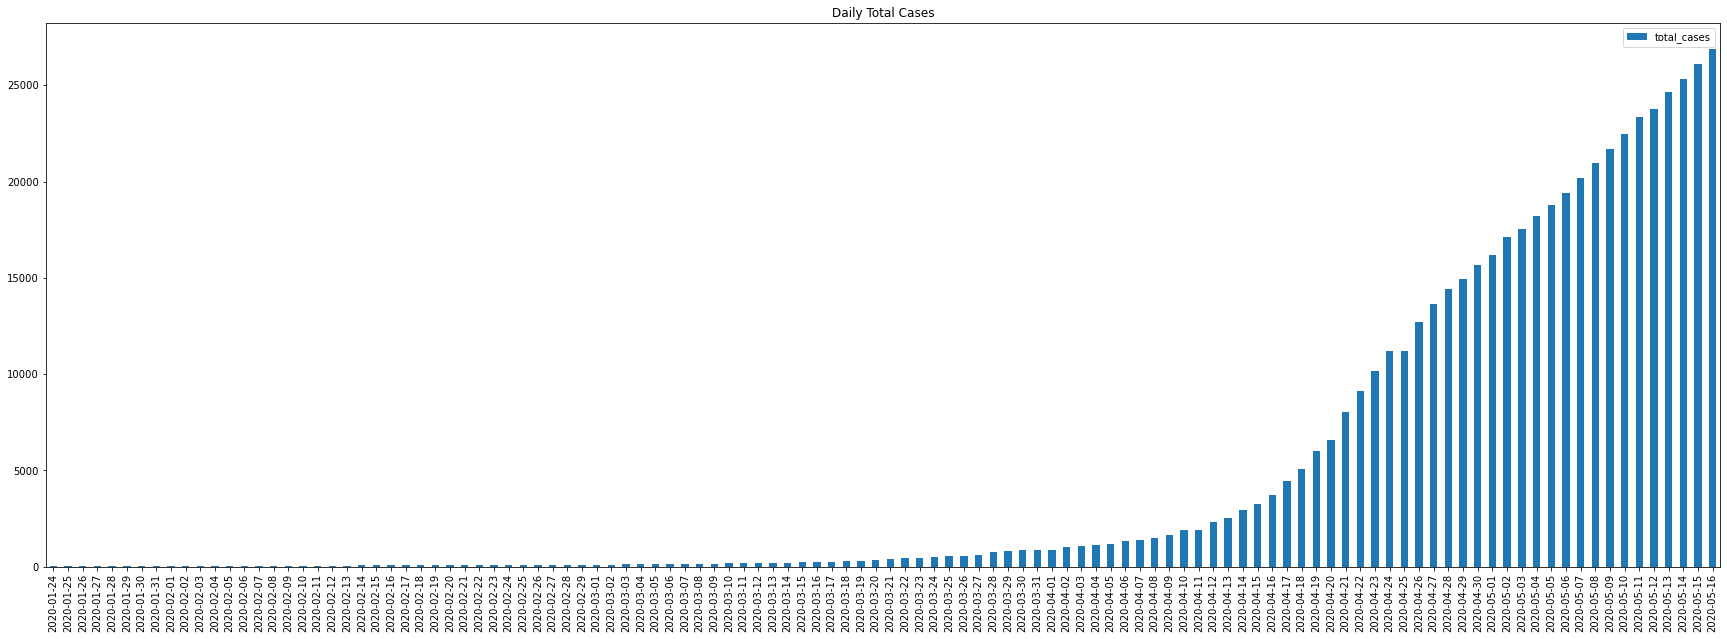

In [3]:
ax = covid19DailyCase[['total_cases','date']].plot(kind='bar', figsize=(30,10), title="Daily Total Cases")
ax.set_xticklabels(covid19DailyCase['date']);

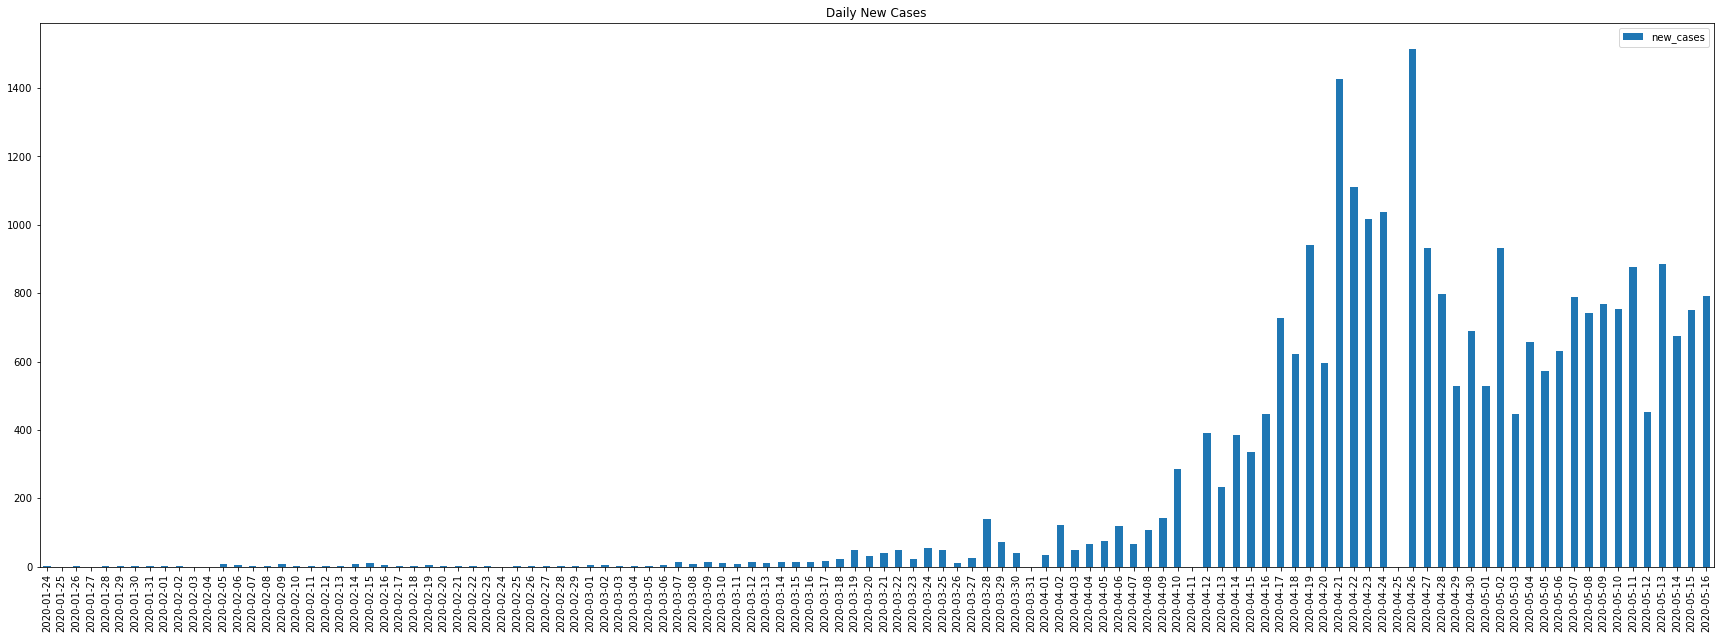

In [4]:
ax = covid19DailyCase[['new_cases','date']].plot(kind='bar', figsize=(30,10), title="Daily New Cases")
ax.set_xticklabels(covid19DailyCase['date']);

In [5]:
## We applied Population Growth Model
#  yi=β1/(1+exp(β2+β3xi))+ϵi
#  https://online.stat.psu.edu/stat501/lesson/15/15.8

In [6]:
# Solving initial condition

# From the graph, we noticed the peak increase at 22/April and 26/April
# Assume the peak growth is at 24/April (halfway point) 
# We use this data to calculate intial beta1 value
beta1 = 2 * covid19DailyCase[covid19DailyCase['date'] == '2020-04-22'].total_cases.iloc[0]

# We use 24/Jan and 06/Apr value as two starting point to calculate inital beta2 and beta3 values
import numpy as np

#np.array([[1, covid19SG[covid19SG['date'] == '2020-01-24'].index], [1, covid19SG[covid19SG['date'] == '2020-04-06'].index]])
#np.log(beta1.values/(covid19SG[covid19SG['date'] == '2020-01-24'].total_cases - 1))
#np.log(beta1.values/(covid19SG[covid19SG['date'] == '2020-04-06'].total_cases - 1))
A = np.array([[1, 0], [1, 73]])
y = np.array([9.118773,2.635666])
beta2, beta3 = np.linalg.solve(A,y)
beta1, beta2, beta3


(18250, 9.118773, -0.08880968493150683)

In [7]:
initialY = beta1 / (1 + np.exp(beta2 + beta3 * covid19SG.index.values))
# To continue using Non-linear Least Squared Method
# https://en.wikipedia.org/wiki/Non-linear_least_squares

In [8]:
# We use python library for curve_fit
from scipy.optimize import curve_fit

def populationGrowthModel(x, b1, b2, b3):
    return b1 / (1 + np.exp(b2 + b3 * x))

# fit model on original data
xGrowth = covid19DailyCase.index.values
yGrowth = covid19DailyCase['total_cases'].values

poptGrowth, pcovGrowth = curve_fit(populationGrowthModel, xGrowth, yGrowth, p0=[beta1, beta2, beta3])
poptGrowth, pcovGrowth

(array([ 2.81686038e+04,  1.24758225e+01, -1.30478831e-01]),
 array([[ 1.64583552e+05, -8.00100303e+01,  9.97756315e-01],
        [-8.00100303e+01,  6.38126382e-02, -7.45104852e-04],
        [ 9.97756315e-01, -7.45104852e-04,  8.78273896e-06]]))

In [9]:
# fit model on 3 day average 
yGrowthAvg3 = covid19DailyCase['total_cases'].rolling(window=3).mean()

poptGrowthAvg, pcovGrowthAvg = curve_fit(populationGrowthModel, xGrowth, np.nan_to_num(yGrowthAvg3), p0=[beta1, beta2, beta3])
poptGrowthAvg, pcovGrowthAvg

(array([ 2.74787703e+04,  1.28479012e+01, -1.33632363e-01]),
 array([[ 1.40786044e+05, -7.22296886e+01,  8.91455757e-01],
        [-7.22296886e+01,  6.03879863e-02, -6.99620155e-04],
        [ 8.91455757e-01, -6.99620155e-04,  8.17752671e-06]]))

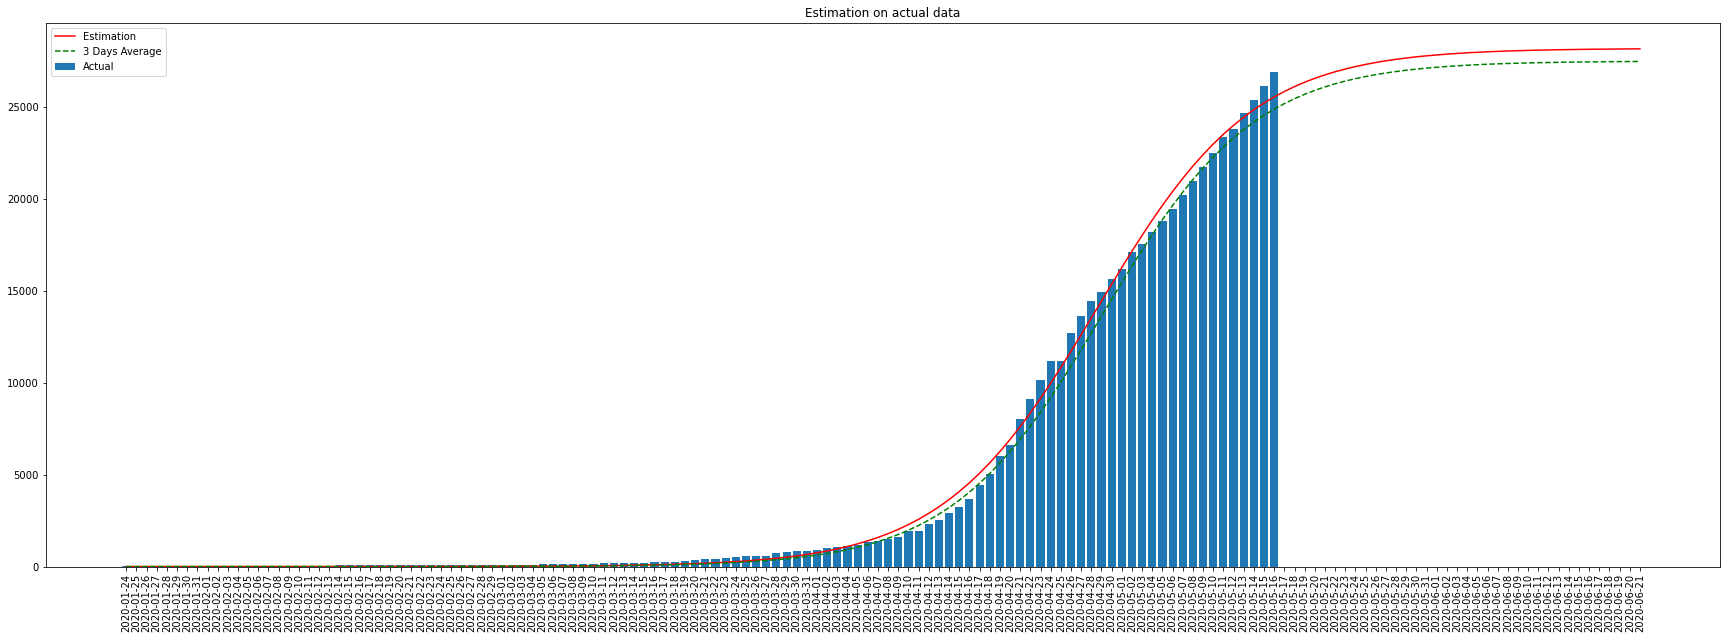

array([ 2.81686038e+04,  1.24758225e+01, -1.30478831e-01])

In [10]:
import matplotlib.pyplot as plt
estimationRage = range(0,150)

plt.figure(figsize=(30,10))
plt.plot(estimationRage, populationGrowthModel(estimationRage, *poptGrowth), 'r', label='Estimation')
plt.plot(estimationRage, populationGrowthModel(estimationRage, *poptGrowthAvg), '--g', label='3 Days Average')
plt.bar(estimationRage, np.pad(covid19DailyCase['total_cases'].values, 
        (0, len(estimationRage)-covid19DailyCase['total_cases'].size), 'constant'),label='Actual')
plt.legend();
plt.title('Estimation on actual data')
plt.xticks(estimationRage,np.array('2020-01-24', dtype=np.datetime64) + estimationRage, rotation=90)
plt.show()
poptGrowth

In [11]:
## Verify its change rate
# Change rate is a symmetric function, which is different from most of the observations on other countries
#ax = plt.figure(figsize=(30,10))
#ax = plt.plot(np.diff(populationGrowthModel(estimationRage, *poptGrowth)))

In [12]:
## (BETA) We enhance the estimation using Exponentially modified Gaussian distribution
# https://en.wikipedia.org/wiki/Exponentially_modified_Gaussian_distribution
from scipy.stats import exponnorm
from scipy.optimize import curve_fit

def populationGrowthRateModel(x, loc, scale, K, d):
    return d * exponnorm.pdf(x, K, loc, scale)

xGrowthRate = covid19DailyCase.index.values
yGrowthRate = covid19DailyCase['new_cases'].values

poptRate, pcovRate = curve_fit(populationGrowthRateModel, xGrowthRate, yGrowthRate)
print(poptRate, pcovRate)

yGrowthRateAvg3 = covid19DailyCase['new_cases'].rolling(window=3).mean()
poptGrowthRateAvg, pcovGrowthRateAvg = curve_fit(populationGrowthRateModel, xGrowthRate, np.nan_to_num(yGrowthRateAvg3))
poptGrowthRateAvg, pcovGrowthRateAvg


[8.19739548e+01 3.74027282e+00 1.83674404e+01 6.89723957e+04] [[ 5.87212844e-01  2.54917379e-01 -4.84760597e+00 -9.92004621e+03]
 [ 2.54917379e-01  8.76674532e-01 -7.72176333e+00 -9.01672124e+03]
 [-4.84760597e+00 -7.72176333e+00  1.09740844e+02  2.00627848e+05]
 [-9.92004621e+03 -9.01672124e+03  2.00627848e+05  4.50719624e+08]]


(array([8.29906577e+01, 3.85165865e+00, 1.61711209e+01, 6.36185121e+04]),
 array([[ 1.57418519e-01,  7.17317721e-02, -1.14247284e+00,
         -2.37927308e+03],
        [ 7.17317721e-02,  2.28262426e-01, -1.74695336e+00,
         -2.12672504e+03],
        [-1.14247284e+00, -1.74695336e+00,  2.11466683e+01,
          3.95068523e+04],
        [-2.37927308e+03, -2.12672504e+03,  3.95068523e+04,
          9.05185357e+07]]))

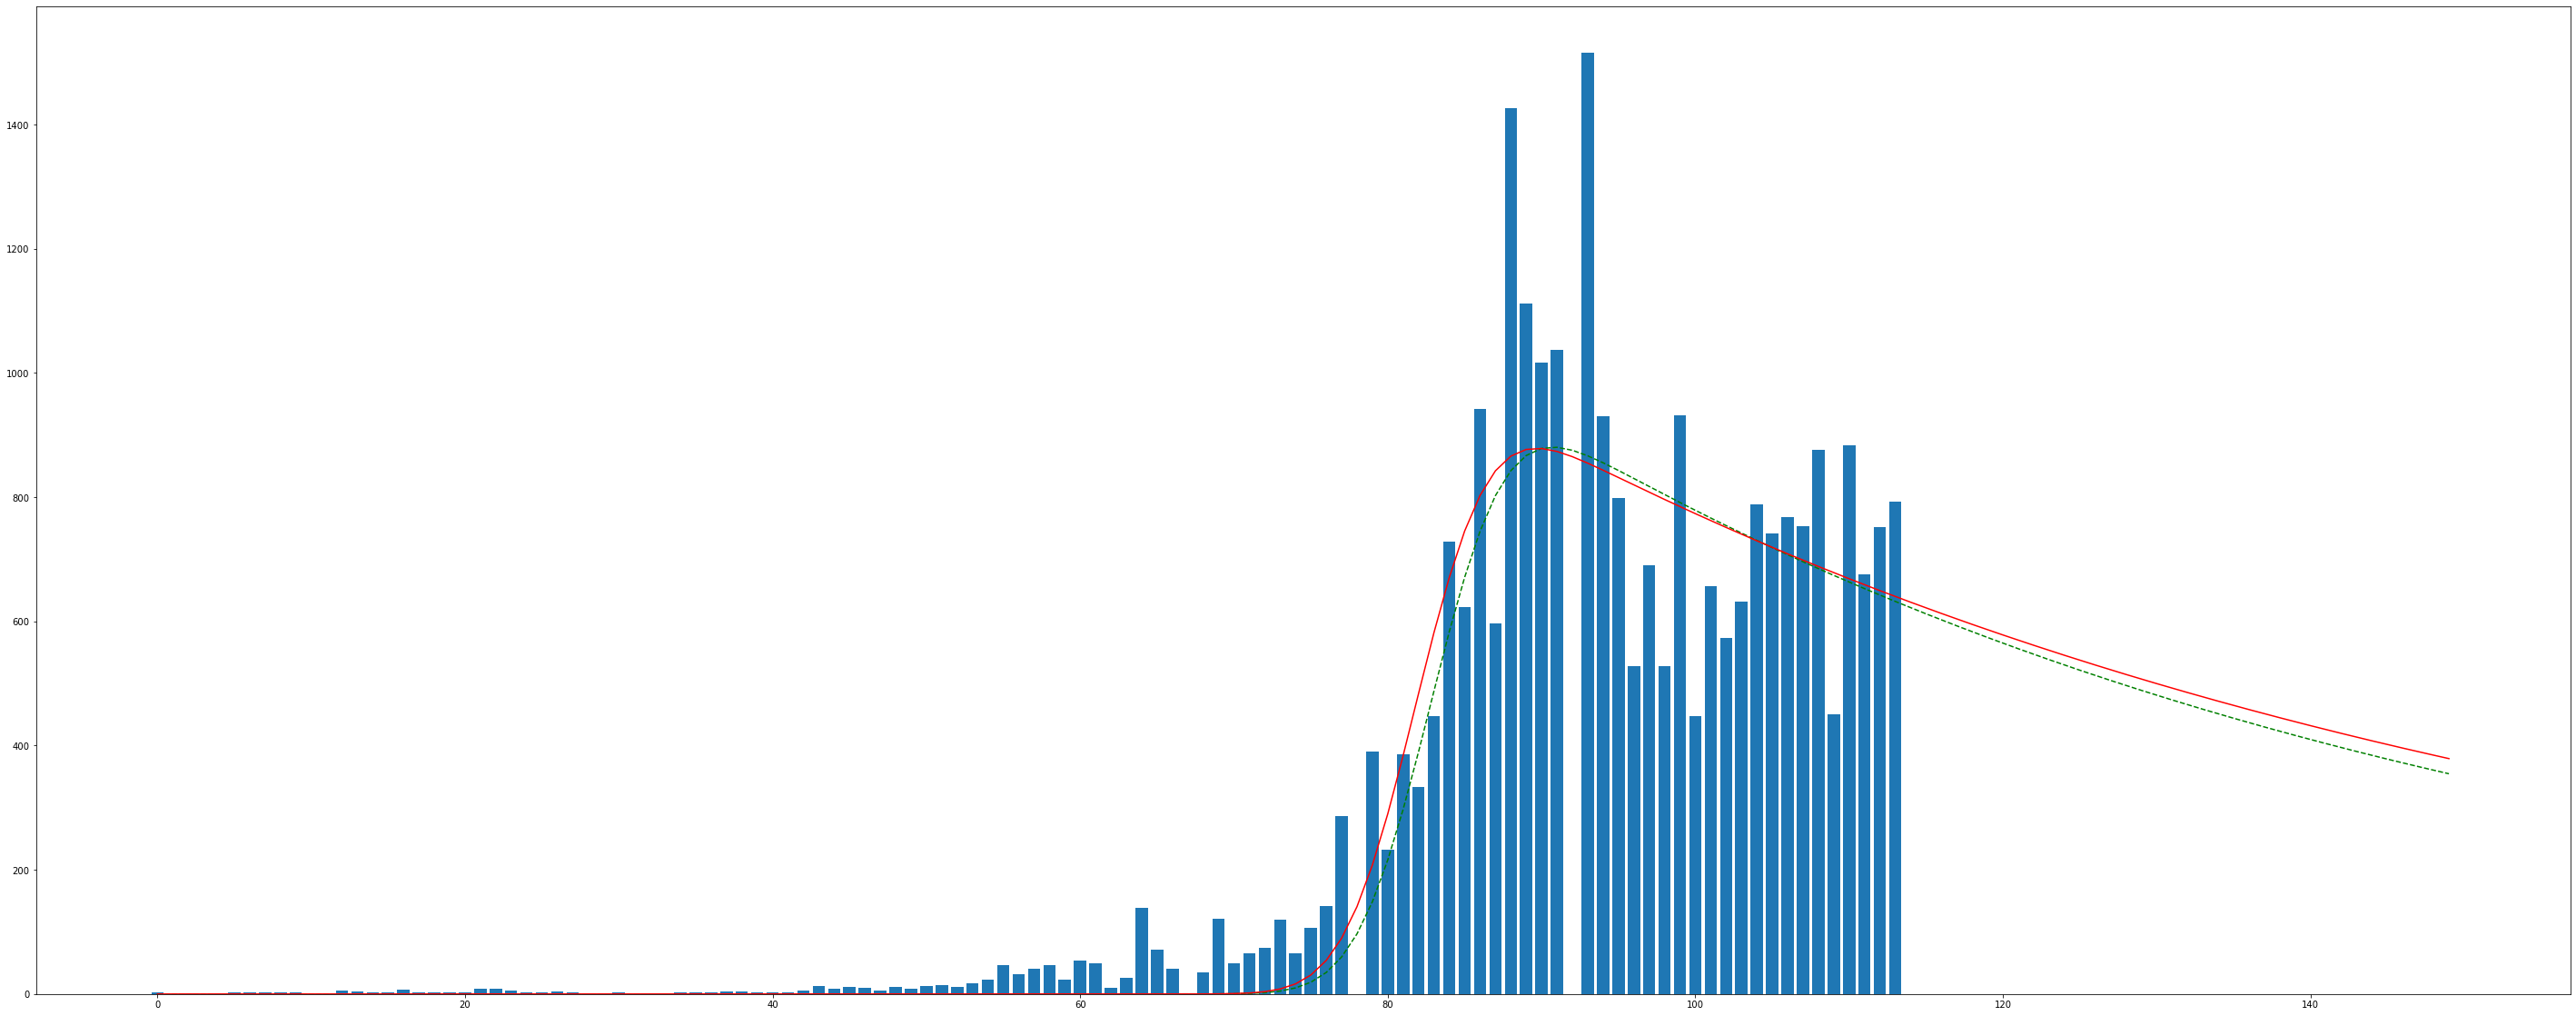

array([9.04134558e-104, 3.10507821e-101, 9.90293963e-099, ...,
       6.89723957e+004, 6.89723957e+004, 6.89723957e+004])

In [13]:
estimationRage = range(0,150)
plt.figure(figsize=(50,20))

plt.plot(estimationRage, populationGrowthRateModel(estimationRage, *poptGrowthRateAvg), '--g', label='3 Days Average')
plt.plot(estimationRage, populationGrowthRateModel(estimationRage, *poptRate), 'r-')
plt.bar(estimationRage, np.pad(covid19SG['new_cases'].values, (0, len(estimationRage)-covid19SG['total_cases'].size), 'constant'))
plt.show()
populationGrowthRateModel(range(0,3000), *poptRate).cumsum()

In [14]:
## 17 May 2020
# There are few phases of Covid 19 situation in Singapore
# Foreign Import -> Local Transmission -> Worker Dorm Outbreak
# 1. Foreign Import cases are cleared to zero after close border policy -> minor impact on total numbers
# 2. Local Transmission cases have been reduced after Circuit Breaker measures -> medium impact on total numbers
# 3. Worker Dorm cases are huge and growing fast -> huge impact on total numbers
# (Experiment) We seperate 2 and 3 into two different models and use the aggregation to simulate the case


In [15]:
def popGrowthRateTwoModel(x, loc1, scale1, K1, d1, loc2, scale2, K2, d2):
    return d1 * exponnorm.pdf(x, K1, loc1, scale1) + d2 * exponnorm.pdf(x, K2, loc2, scale2)

xGrowthRate = covid19DailyCase.index.values
yGrowthRate = covid19DailyCase['new_cases'].values

poptRateTwoMod, pcovRateTwoMod = curve_fit(popGrowthRateTwoModel, xGrowthRate, yGrowthRate,
                                           np.concatenate((poptRate,np.array([110, 4.0, 1.5, 8e+04]))), maxfev=3600)
print(poptRateTwoMod, pcovRateTwoMod)

yGrowthRateAvg3 = covid19DailyCase['new_cases'].rolling(window=3).mean()
poptGrowthRateTwoModAvg, pcovGrowthRateTwoModAvg = curve_fit(popGrowthRateTwoModel, xGrowthRate, 
                                                             np.nan_to_num(yGrowthRateAvg3),
                                                              np.concatenate((poptRate,np.array([110, 4.0, 1.5, 8e+04]))),
                                                             maxfev=12000)
poptGrowthRateTwoModAvg, pcovGrowthRateTwoModAvg



[8.88707869e+01 5.86466975e+00 3.02588197e-02 1.38121278e+04
 1.02137655e+02 7.28430862e+00 1.88560452e+00 2.27329553e+04] [[ 7.31520705e+05  2.02483067e+04 -1.25648551e+05 -1.14674489e+07
   1.41283169e+04  1.89595721e+04 -1.80857909e+04 -4.33895392e+07]
 [ 2.02483067e+04  5.62084766e+02 -3.47733723e+03 -3.06338243e+05
   3.65336800e+02  5.00898478e+02 -4.74321453e+02 -1.12614988e+06]
 [-1.25648551e+05 -3.47733723e+03  2.15820837e+04  1.97431914e+06
  -2.43906357e+03 -3.26731214e+03  3.11868638e+03  7.48856401e+06]
 [-1.14674489e+07 -3.06338243e+05  1.97431914e+06  2.68161338e+08
  -4.63410527e+05 -5.04161029e+05  5.21028792e+05  1.38372705e+09]
 [ 1.41283169e+04  3.65336800e+02 -2.43906357e+03 -4.63410527e+05
   1.17026065e+03  1.02448890e+03 -1.18037576e+03 -3.49525917e+06]
 [ 1.89595721e+04  5.00898478e+02 -3.26731214e+03 -5.04161029e+05
   1.02448890e+03  1.01374660e+03 -1.09542201e+03 -3.05134563e+06]
 [-1.80857909e+04 -4.74321453e+02  3.11868638e+03  5.21028792e+05
  -1.18037576

(array([9.03657738e+01, 6.24377694e+00, 3.01823416e-02, 1.51820813e+04,
        1.03378185e+02, 5.58078097e+00, 2.36176171e+00, 1.92340995e+04]),
 array([[ 2.46438537e+05,  6.86467228e+03, -3.96862435e+04,
         -1.92110361e+06,  4.45258645e+02,  2.06628245e+03,
         -2.81364163e+03, -4.53158597e+06],
        [ 6.86467228e+03,  1.91457328e+02, -1.10542195e+03,
         -5.26171966e+04,  1.12067224e+01,  5.60596323e+01,
         -7.58700717e+01, -1.20707180e+05],
        [-3.96862435e+04, -1.10542195e+03,  6.39105528e+03,
          3.09623837e+05, -7.21265666e+01, -3.33224310e+02,
          4.53927099e+02,  7.31640781e+05],
        [-1.92110361e+06, -5.26171966e+04,  3.09623837e+05,
          1.87695106e+07, -9.71241803e+03, -2.30374782e+04,
          3.40245400e+04,  6.30663394e+07],
        [ 4.45258645e+02,  1.12067224e+01, -7.21265666e+01,
         -9.71241803e+03,  2.37536163e+01,  2.06354622e+01,
         -4.14850325e+01, -1.05149534e+05],
        [ 2.06628245e+03,  5.60596

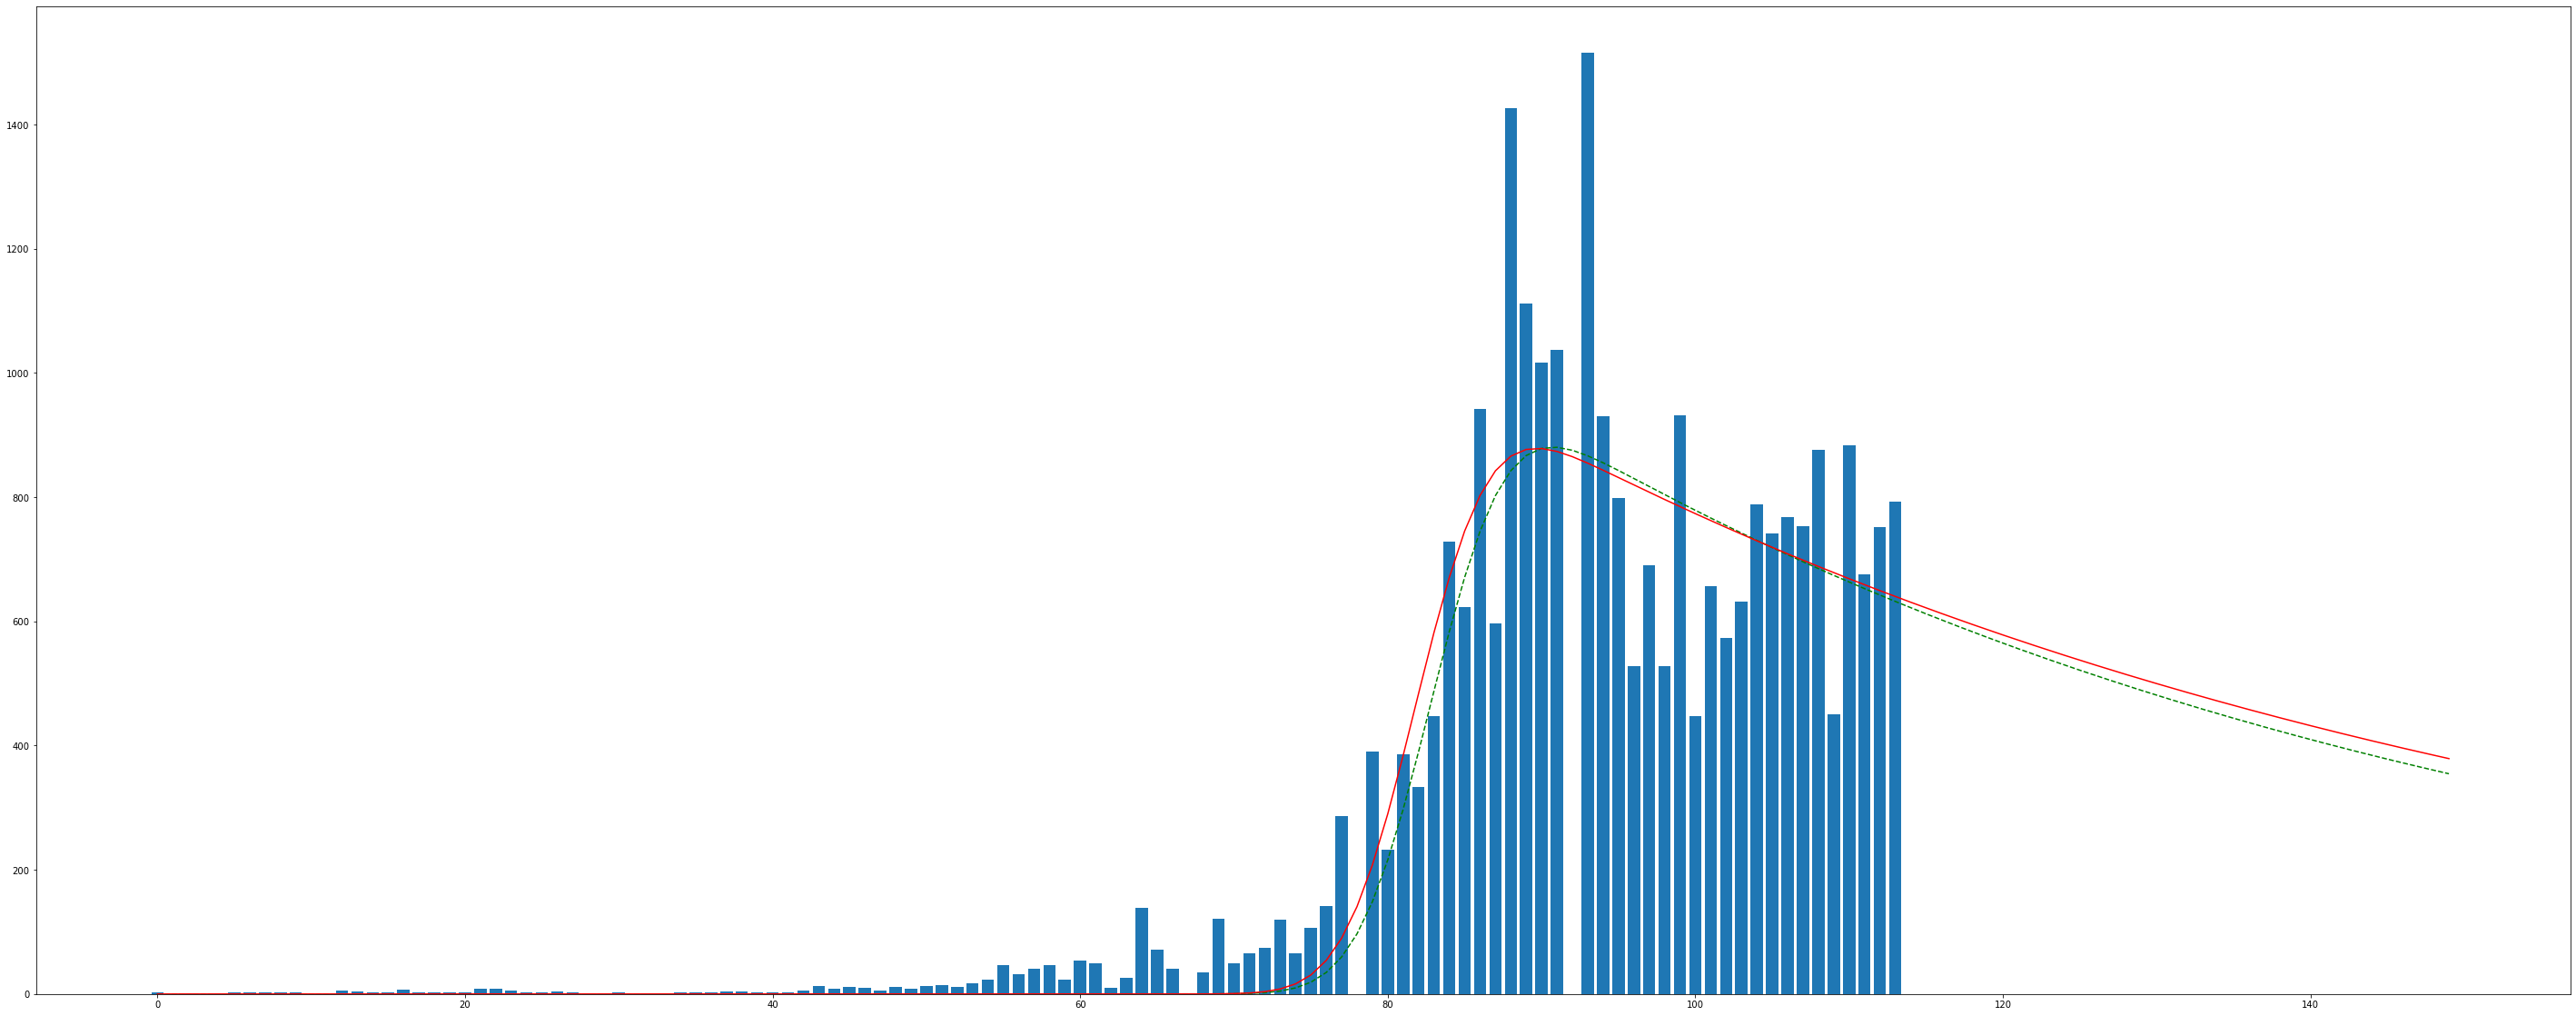

array([9.04134558e-104, 3.10507821e-101, 9.90293963e-099, ...,
       6.89723957e+004, 6.89723957e+004, 6.89723957e+004])

In [16]:
estimationRage = range(0,150)
plt.figure(figsize=(50,20))

plt.plot(estimationRage, populationGrowthRateModel(estimationRage, *poptGrowthRateAvg), '--g', label='3 Days Average')
plt.plot(estimationRage, populationGrowthRateModel(estimationRage, *poptRate), 'r-')
plt.bar(estimationRage, np.pad(covid19SG['new_cases'].values, (0, len(estimationRage)-covid19SG['total_cases'].size), 'constant'))
plt.show()
populationGrowthRateModel(range(0,3000), *poptRate).cumsum()

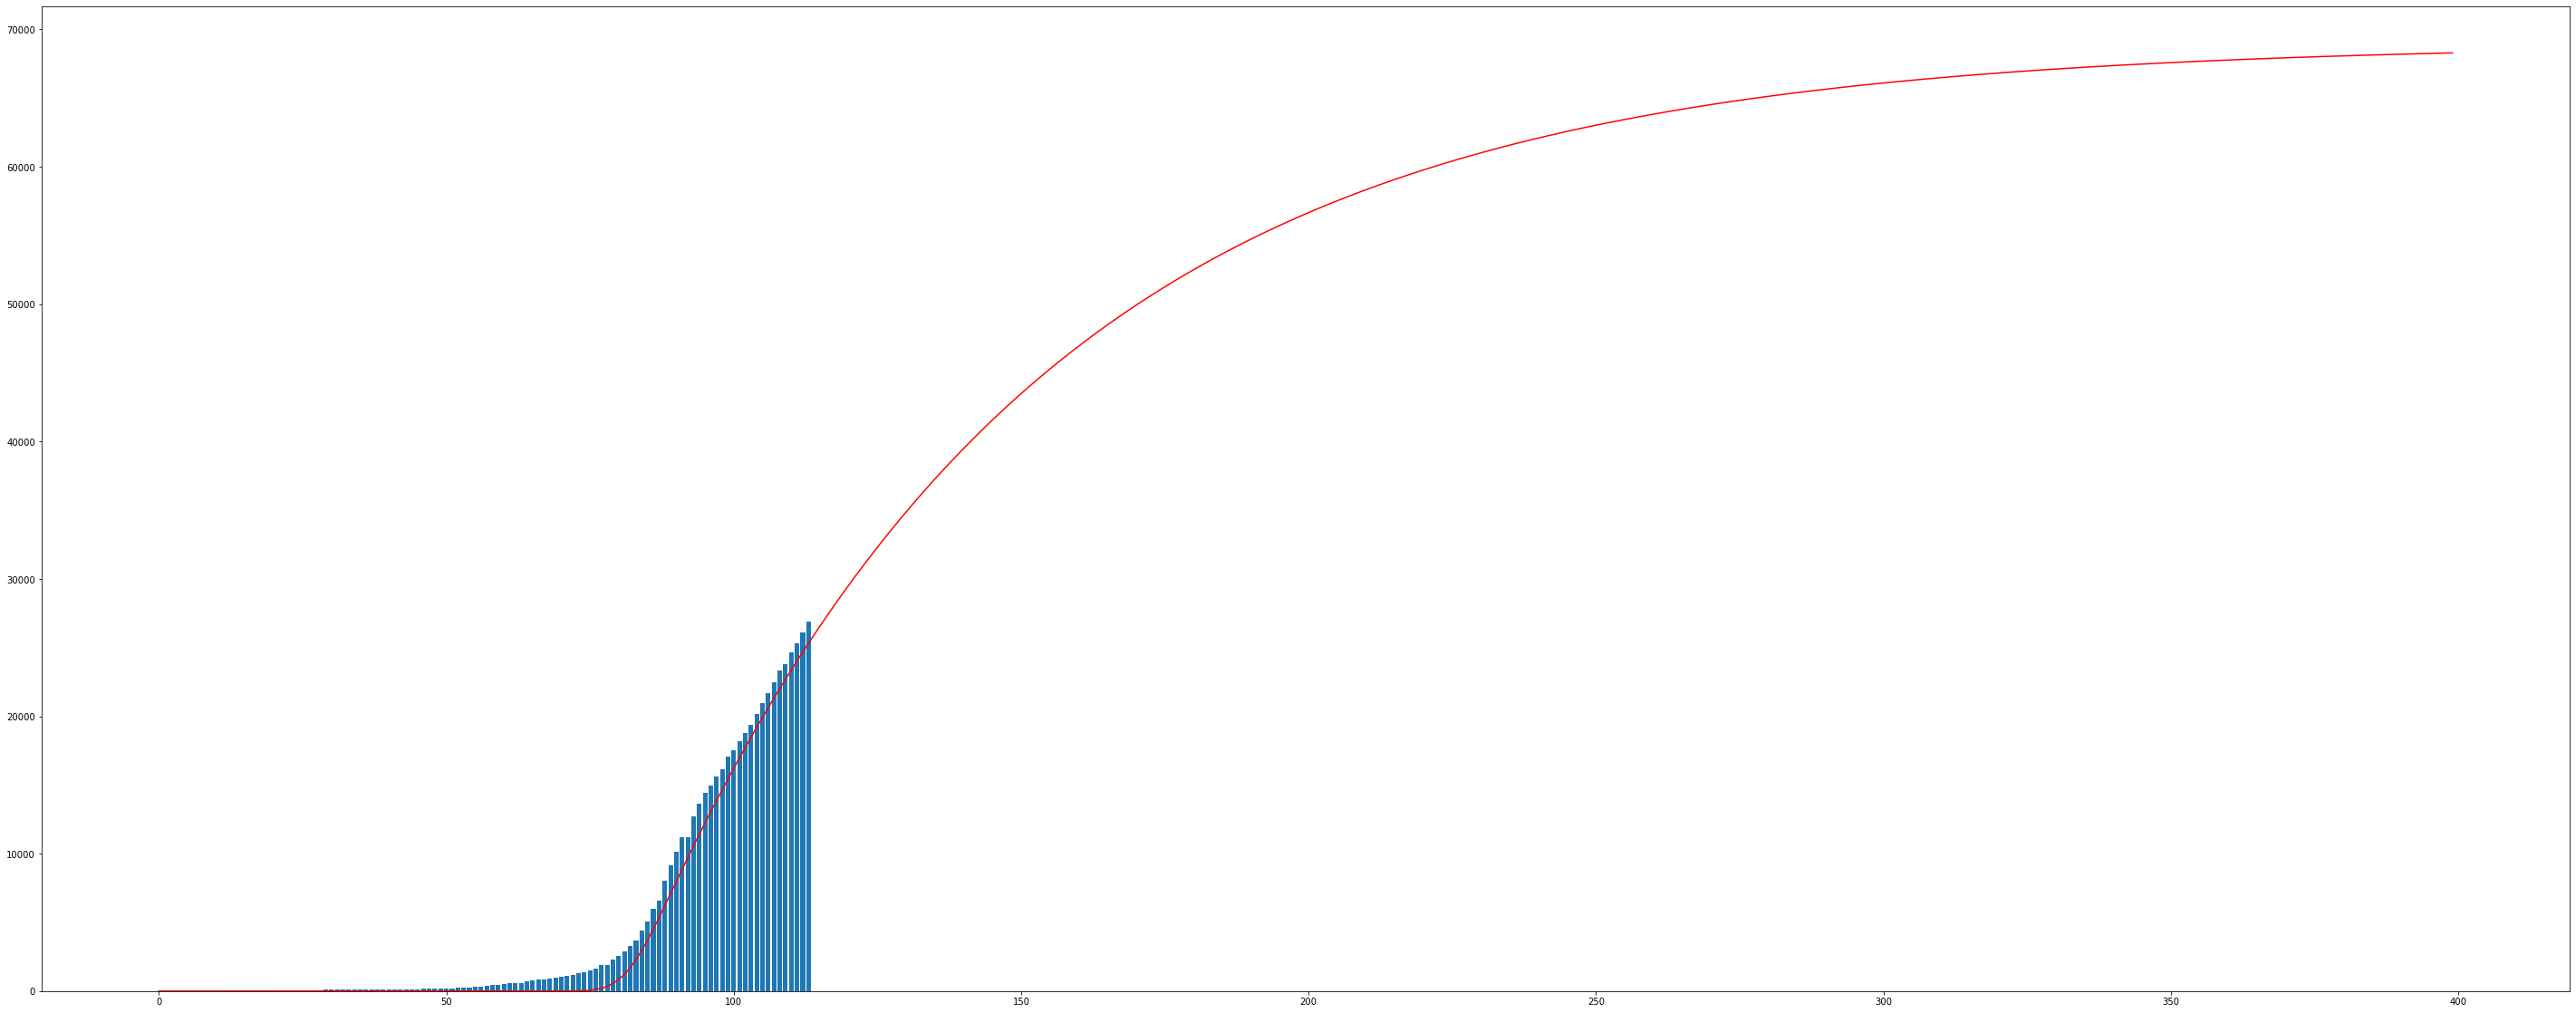

In [17]:
estimationRage = range(0,400)
plt.figure(figsize=(50,20))
plt.plot(estimationRage, populationGrowthRateModel(estimationRage, *poptRate).cumsum(), 'r-')
plt.bar(estimationRage, np.pad(covid19SG['total_cases'].values, (0, len(estimationRage)-covid19SG['total_cases'].size), 'constant'))
plt.show()

In [18]:
## (Experiment) Go back to original population growth model definetion

def populationGrowthRateModel(x, rate, capacity, N):
    return rate * capacity /(capacity - N) * N

xGrowthRate = covid19DailyCase.index.values
yGrowthRate = covid19DailyCase['new_cases'].values

poptRate, pcovRate = curve_fit(populationGrowthRateModel, xGrowthRate, yGrowthRate)
poptRate, pcovRate

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(array([1., 1., 1.]),
 array([[inf, inf, inf],
        [inf, inf, inf],
        [inf, inf, inf]]))